# Чтение данных

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import math
import pickle
from sklearn.metrics import roc_auc_score
import optuna
import catboost as cb
import warnings
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

In [3]:
# !wget -O "train.csv" -q "https://www.dropbox.com/scl/fi/2j7db5uhs7wytqugzaigp/train_dataset_.csv?rlkey=x7ucw1skys4ziawoa1b30uivg&dl=0"
your_path_to_csv = '../data/train_dataset.csv' #Поменять на ваш путь до csv файла
data = pd.read_csv(your_path_to_csv)

# Target Rate

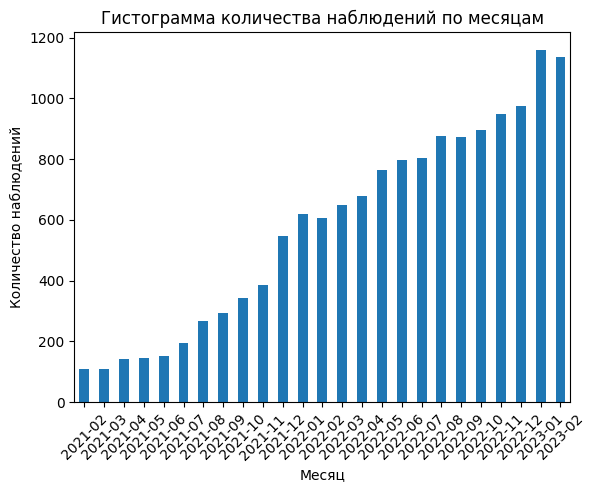

In [4]:
# Количество наблюдений по месяцам
df = data.copy()
df['report_date'] = pd.to_datetime(df['report_date'])

monthly_counts = df.groupby(df['report_date'].dt.to_period("M")).size()

monthly_counts.plot(kind='bar')
plt.xlabel('Месяц')
plt.ylabel('Количество наблюдений')
plt.title('Гистограмма количества наблюдений по месяцам')
plt.xticks(rotation=45)
plt.show()

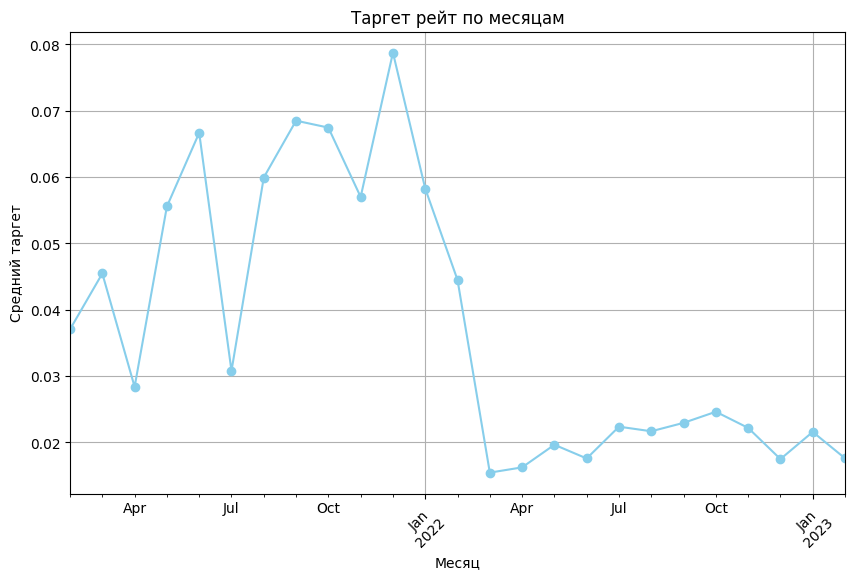

In [5]:
# Target Rate по месяцам
monthly_target = df.groupby(df['report_date'].dt.to_period('M'))['target'].mean()

plt.figure(figsize=(10, 6))
monthly_target.plot(kind='line', marker='o', color='skyblue')
plt.xlabel('Месяц')
plt.ylabel('Средний таргет')
plt.title('Таргет рейт по месяцам')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [6]:
# Нормализация Target Rate для стабилизации
tmp = df[(df.report_date > '2022-02-01')]

tmp1 = df[(df.report_date == '2021-02-01')]
percent_to_remove = 0.4
mask = tmp1['target'] == 1
indices_to_remove = tmp1[mask].sample(frac=percent_to_remove).index
tmp1 = tmp1.drop(indices_to_remove)

tmp2 = df[(df.report_date == '2021-03-01')]
percent_to_remove = 0.55
mask = tmp2['target'] == 1
indices_to_remove = tmp2[mask].sample(frac=percent_to_remove).index
tmp2 = tmp2.drop(indices_to_remove)

tmp3 = df[(df.report_date == '2021-04-01') | (df.report_date == '2021-07-01')]
percent_to_remove = 0.2
mask = tmp3['target'] == 1
indices_to_remove = tmp3[mask].sample(frac=percent_to_remove).index
tmp3 = tmp3.drop(indices_to_remove)

tmp4 = df[(df.report_date == '2021-05-01') | (df.report_date == '2021-06-01')]
percent_to_remove = 0.6
mask = tmp4['target'] == 1
indices_to_remove = tmp4[mask].sample(frac=percent_to_remove).index
tmp4 = tmp4.drop(indices_to_remove)

tmp5 = df[(df.report_date == '2021-08-01') | (df.report_date == '2021-09-01') \
          | (df.report_date == '2021-10-01') | (df.report_date == '2021-11-01')]
percent_to_remove = 0.7
mask = tmp5['target'] == 1
indices_to_remove = tmp5[mask].sample(frac=percent_to_remove).index
tmp5 = tmp5.drop(indices_to_remove)

tmp6 = df[(df.report_date == '2021-12-01')]
percent_to_remove = 0.7
mask = tmp6['target'] == 1
indices_to_remove = tmp6[mask].sample(frac=percent_to_remove).index
tmp6 = tmp6.drop(indices_to_remove)

In [7]:
new_df = pd.concat([tmp, tmp1, tmp2, tmp3, tmp4, tmp5, tmp6], axis = 0)

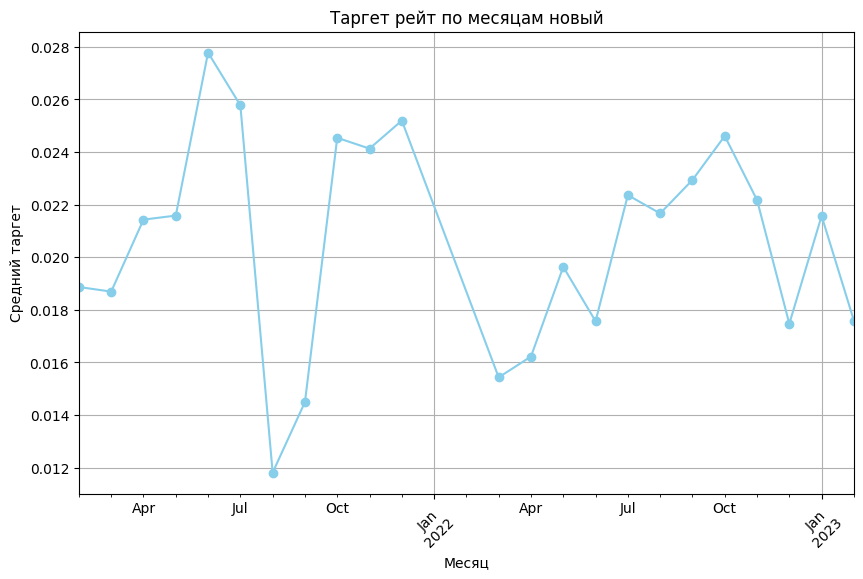

In [8]:
# Сбалансированный Target Rate
monthly_target = new_df.groupby(new_df['report_date'].dt.to_period('M'))['target'].mean()

plt.figure(figsize=(10, 6))
monthly_target.plot(kind='line', marker='o', color='skyblue')
plt.xlabel('Месяц')
plt.ylabel('Средний таргет')
plt.title('Таргет рейт по месяцам новый')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [9]:
print(f"Размер выборки с изначальным таргет рейтом: {df.shape[0]}")
print(f"Размер выборки с новым таргет рейтом: {new_df.shape[0]}")

Размер выборки с изначальным таргет рейтом: 14456
Размер выборки с новым таргет рейтом: 13126


# Достаем Финальные Фичи из GettingFeatures

In [10]:
feats = ['col2213', 'col521', 'col1273', 'col189', 'col465', 'col2293', 'col1904',
         'col593', 'col221', 'col2588', 'col1919', 'col537', 'col1865', 'col2209',
         'col1847', 'col57', 'col170', 'col2636', 'col620', 'col1623', 'col2207',
         'col569', 'col93', 'col2173', 'col1918', 'col1070', 'col513', 'col819',
         'col181', 'col2479', 'col545', 'col1864', 'col2505', 'col1913', 'col609',
         'col529', 'col1973', 'col173', 'col153', 'col1886', 'col1492', 'col1962',
         'col528', 'col2524', 'col561', 'col1170', 'col2191', 'col1823', 'col1961',
         'col2311', 'col2365', 'col2663', 'col1894', 'col601', 'col2221', 'col2014',
         'col553', 'col49', 'col1824', 'col1867', 'col592', 'col2180', 'col1871',
         'col2177', 'col1053', 'col461', 'col85', 'col793', 'col1841', 'col2169',
         'col1939', 'col2216', 'col2172', 'col1960', 'col2480', 'col2167', 'col1849',
         'col1938', 'col145', 'col1943', 'col2215', 'col1840', 'col201', 'col1931',
         'col1457', 'col1045', 'col2461', 'col1869', 'col137', 'col2317', 'col1968',
         'col2212', 'col161', 'col237', 'col1029', 'col536', 'col1956', 'col457',
         'col585', 'col1827', 'col2174', 'col1647', 'col129', 'col2183', 'col1829',
         'col1513', 'col1883', 'col209', 'col577', 'col169', 'col1843', 'col1061',
         'col1903', 'col1885'
]

In [11]:
df = new_df.copy().reset_index(drop=True)

final_num_feats = df[feats].select_dtypes('number').columns.unique().tolist()
final_categ_feats = df[feats].select_dtypes('object').columns.unique().tolist()

extras = ['client_id', 'report_date']
target = ['target']

df = df[final_num_feats+final_categ_feats+extras+target]

In [12]:
def convert_to_float(df):
    for col in tqdm(df.columns):
        try:
            if df[col].apply(lambda x: pd.to_numeric(x, errors='coerce')).notna().any():
                df[col] = pd.to_numeric(df[col], errors='coerce')
        except:
            pass
convert_to_float(df)

100%|██████████| 117/117 [00:06<00:00, 18.50it/s]


In [13]:
final_num_feats = df[feats].select_dtypes('number').columns.unique().tolist()
final_categ_feats = df[feats].select_dtypes('object').columns.unique().tolist()

In [14]:
df[final_categ_feats] = df[final_categ_feats].fillna('-999')
df[final_categ_feats] = df[final_categ_feats].astype(str)

In [15]:
# Разбиваем на Train-valid-OutOfTime
train_mask = df.report_date <= '2022-09-01'
valid_mask = (df.report_date > '2022-09-01') & (df.report_date <= '2023-01-01')
oot_mask = df.report_date > '2023-01-01'

df.loc[train_mask, 'sample'] = 'Train'
df.loc[valid_mask, 'sample'] = 'Valid'
df.loc[oot_mask, 'sample'] = 'OOT'

In [16]:
X_train = df[df['sample'] == 'Train'][final_num_feats+final_categ_feats]
X_val = df[df['sample'] == 'Valid'][final_num_feats+final_categ_feats]
X_oot = df[df['sample'] == 'OOT'][final_num_feats+final_categ_feats]

y_train = df[df['sample'] == 'Train'][target]
y_val = df[df['sample'] == 'Valid'][target]
y_oot = df[df['sample'] == 'OOT'][target]

In [17]:
print(f"Размер TRAIN выборки: {int(X_train.shape[0]/df.shape[0]*100)}%")
print(f"Размер OOS выборки: {int(X_val.shape[0]/df.shape[0]*100)}%")
print(f"Размер OOT выборки: {int(X_oot.shape[0]/df.shape[0]*100)}%")

Размер TRAIN выборки: 61%
Размер OOS выборки: 30%
Размер OOT выборки: 8%


# Кастомный Бустинг

In [18]:
class Boosting:

    def __init__(self, X_train, X_val, X_oot, y_train, y_val, y_oot, cat_features, params = None):
        print("Init...")
        self.X_train = X_train
        self.X_val = X_val
        self.X_oot = X_oot
        self.y_train = y_train
        self.y_val = y_val
        self.y_oot = y_oot
        self.cat_features = cat_features
        self.params = params
        self.model = None
        self.best_params = None
        self.top_features = None
        self.train_pool = cb.Pool(data = X_train, label = y_train, cat_features = cat_features)
        self.val_pool = cb.Pool(data = X_val, label = y_val, cat_features = cat_features)
        self.file_path = None
        self.oot_preds = None
        print("Init Finished!")

    def train(self):
        if self.params is None:
            model = cb.CatBoostClassifier(
                learning_rate = 0.303,
                depth = 3,
                l2_leaf_reg = 2.437,
                random_seed = 42,
                min_data_in_leaf = 30,
                one_hot_max_size = 40,
                colsample_bylevel = 0.079,
                loss_function = 'Logloss',
                task_type = 'CPU',
                iterations = 1000,
                use_best_model = True,
                verbose = 100,
                thread_count = -1,
                early_stopping_rounds = 100,
                eval_metric = 'AUC',
                boosting_type = 'Plain',
                bootstrap_type = 'MVS'
            )
        else:
            self.params["verbose"] = 100
            self.params["iterations"] = 1000
            model = cb.CatBoostClassifier(**self.params)

        model.fit(
            self.train_pool,
            eval_set = self.val_pool
        )

        y_train_pred = model.predict_proba(self.X_train)[:, 1]
        y_val_pred = model.predict_proba(self.X_val)[:, 1]

        roc_auc_tr = roc_auc_score(self.y_train, y_train_pred)
        roc_auc_val = roc_auc_score(self.y_val, y_val_pred)

        print("ROC AUC на TRAIN выборке:", roc_auc_tr)
        print("ROC AUC на VALID выборке:", roc_auc_val)

        self.model = model

    def optimize_hyperparams(self):

        def objective(trial):
            params = {
                "objective" : trial.suggest_categorical("objective", ["Logloss"]),
                "learning_rate" : trial.suggest_loguniform("learning_rate", 1e-5, 1e0),
                "l2_leaf_reg" : trial.suggest_loguniform("l2_leaf_reg", 1e-2, 3e0),
                "colsample_bylevel" : trial.suggest_float("colsample_bylevel", 0.01, 0.1, log = True),
                "depth" : trial.suggest_int("depth", 2, 5),
                "boosting_type" : trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
                "bootstrap_type" : trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
                "min_data_in_leaf" : trial.suggest_int("min_data_in_leaf", 2, 50),
                "one_hot_max_size" : trial.suggest_int("one_hot_max_size", 2, 50),
                "iterations" : trial.suggest_int("iterations", 500, 3500),
                "eval_metric" : "AUC"
            }

            if params["bootstrap_type"] == "Bayesian":
                params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
            elif params["bootstrap_type"] == "Bernoulli":
                params["subsample"] = trial.suggest_float("subsample", 0.1, 1, log = True)

            model = cb.CatBoostClassifier(
                loss_function = 'Logloss',
                random_seed = 42,
                task_type = 'CPU',
                use_best_model = True,
                verbose = False,
                **params
            )

            model.fit(
                self.train_pool,
                eval_set = self.val_pool
            )

            y_pred = model.predict_proba(self.X_val)[:, 1]

            roc_auc = roc_auc_score(self.y_val, y_pred)

            return roc_auc

        study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps = 5), direction = "maximize")
        study.optimize(objective, n_trials = 100, timeout = 3600)

        self.best_params = study.best_params

        print("Best params:", self.best_params)

    def save_model(self, file_path):
        self.file_path = file_path
        with open(file_path, "wb") as f:
            pickle.dump(self.model, f)

    def score_oot(self):
        if self.file_path is None:
            boosting = self.model
        else:
            with open(self.file_path, 'rb') as file:
                boosting = pickle.load(file)

        y_pred = boosting.predict_proba(self.X_oot[boosting.feature_names_])[:,1]
        self.oot_preds = y_pred
        roc_auc_oot = roc_auc_score(self.y_oot, y_pred)
        print("ROC AUC на OOT выборке:", roc_auc_oot)

    def show_feats_imp(self):
        if self.model is None:
            raise ValueError("Model not found!")

        feature_importance = self.model.feature_importances_
        if len(feature_importance) > 80:
            sorted_idx = np.argsort(feature_importance)[int(len(feature_importance)*0.6):]
        else:
            sorted_idx = np.argsort(feature_importance)

        plt.figure(figsize=(15, 10))
        plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
        plt.yticks(range(len(sorted_idx)), np.array(self.model.feature_names_)[sorted_idx])
        plt.title("Feature Importance")
        plt.show()

        self.top_features = np.flip(np.array(self.model.feature_names_)[sorted_idx])
        print(self.top_features)

    def top_feats_selection(self):

        top = []
        roc_tr = []
        roc_val = []
        roc_oot = []

        for col in tqdm(self.top_features):

            top.append(col)
            top_cat = list(set(self.cat_features) & set(top))

            train_pool = cb.Pool(data = self.X_train[top], label = self.y_train, cat_features = top_cat)
            val_pool = cb.Pool(data = self.X_val[top], label = self.y_val, cat_features = top_cat)

            if self.params is None:
                model = cb.CatBoostClassifier(
                    learning_rate = 0.303,
                    depth = 3,
                    l2_leaf_reg = 2.437,
                    random_seed = 42,
                    min_data_in_leaf = 30,
                    one_hot_max_size = 40,
                    colsample_bylevel = 0.079,
                    loss_function = 'Logloss',
                    task_type = 'CPU',
                    iterations = 1000,
                    use_best_model = True,
                    verbose = False,
                    thread_count = -1,
                    early_stopping_rounds = 100,
                    eval_metric = 'AUC',
                    boosting_type = 'Plain',
                    bootstrap_type = 'MVS'
                )
            else:
                self.params["verbose"] = 0
                self.params["iterations"] = 500
                model = cb.CatBoostClassifier(**self.params)

            model.fit(
                train_pool,
                eval_set = val_pool
            )

            y_train_pred = model.predict_proba(self.X_train[top])[:, 1]
            y_val_pred = model.predict_proba(self.X_val[top])[:, 1]
            y_oot_pred = model.predict_proba(self.X_oot[top])[:, 1]

            roc_auc_tr = roc_auc_score(self.y_train, y_train_pred)
            roc_auc_val = roc_auc_score(self.y_val, y_val_pred)
            roc_auc_oot = roc_auc_score(self.y_oot, y_oot_pred)

            roc_tr.append(roc_auc_tr)
            roc_val.append(roc_auc_val)
            roc_oot.append(roc_auc_oot)

        plt.figure(figsize=(15, 10))
        plt.plot(range(len(self.top_features)), roc_tr, marker = 'o', label = 'Train')
        plt.plot(range(len(self.top_features)), roc_val, marker = 'o', label = 'Valid')
        plt.plot(range(len(self.top_features)), roc_oot, marker = 'o', label = 'OOT')
        plt.xlabel("Number of Top Features")
        plt.ylabel("ROC AUC")
        plt.title("ROC AUC on Top-K Features")
        plt.legend()
        plt.show()

    def one_factor_roc(self):

        for feature in tqdm(self.X_train.columns):
            if self.params is None:
                model = cb.CatBoostClassifier(
                    learning_rate = 0.303,
                    depth = 3,
                    l2_leaf_reg = 2.437,
                    random_seed = 42,
                    min_data_in_leaf = 30,
                    one_hot_max_size = 40,
                    colsample_bylevel = 0.079,
                    loss_function = 'Logloss',
                    task_type = 'CPU',
                    iterations = 1000,
                    use_best_model = True,
                    verbose = False,
                    thread_count = -1,
                    early_stopping_rounds = 100,
                    eval_metric = 'AUC',
                    boosting_type = 'Plain',
                    bootstrap_type = 'MVS'
                )
            else:
                self.params["verbose"] = False
                self.params["iterations"] = 500
                model = cb.CatBoostClassifier(**self.params)

            if feature in self.cat_features:
                train_pool = cb.Pool(data = self.X_train[[feature]], label = self.y_train, cat_features = [feature])
                val_pool = cb.Pool(data = self.X_val[[feature]], label = self.y_val, cat_features = [feature])
            else:
                train_pool = cb.Pool(data = self.X_train[[feature]], label = self.y_train)
                val_pool = cb.Pool(data = self.X_val[[feature]], label = self.y_val)

            model.fit(
                train_pool,
                eval_set = val_pool
            )

            y_train_pred = model.predict_proba(self.X_train[[feature]])[:, 1]
            y_val_pred = model.predict_proba(self.X_val[[feature]])[:, 1]

            roc_auc_tr = roc_auc_score(self.y_train, y_train_pred)
            roc_auc_val = roc_auc_score(self.y_val, y_val_pred)

            story = story.append(pd.DataFrame({
                'features' : [feature],
                'train' : [roc_auc_tr],
                'valid' : [roc_auc_val]
            }), ignore_index = True)

        plt.figure(figsize=(10, 7))
        plt.bar(range(len(story['features'])), story['train'], align = 'center', label = 'Train')
        plt.bar(range(len(story['features'])), story['valid'], align = 'edge', label = 'Valid')
        plt.xlabel("Features")
        plt.ylabel("ROC-AUC")
        plt.title("One-Factor ROC-AUC")
        plt.xticks(range(len(story['features'])), story['features'], rotation = 45)
        plt.legend()
        plt.tight_layout()

# Обучение

Init...
Init Finished!
0:	test: 0.4478592	best: 0.4478592 (0)	total: 244ms	remaining: 4m 3s
100:	test: 0.8042257	best: 0.8049156 (93)	total: 1.21s	remaining: 10.8s
200:	test: 0.8009880	best: 0.8157362 (125)	total: 2.82s	remaining: 11.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8157362019
bestIteration = 125

Shrink model to first 126 iterations.
ROC AUC на TRAIN выборке: 0.9317255177381314
ROC AUC на VALID выборке: 0.8157362018881626
ROC AUC на OOT выборке: 0.7857206803939123


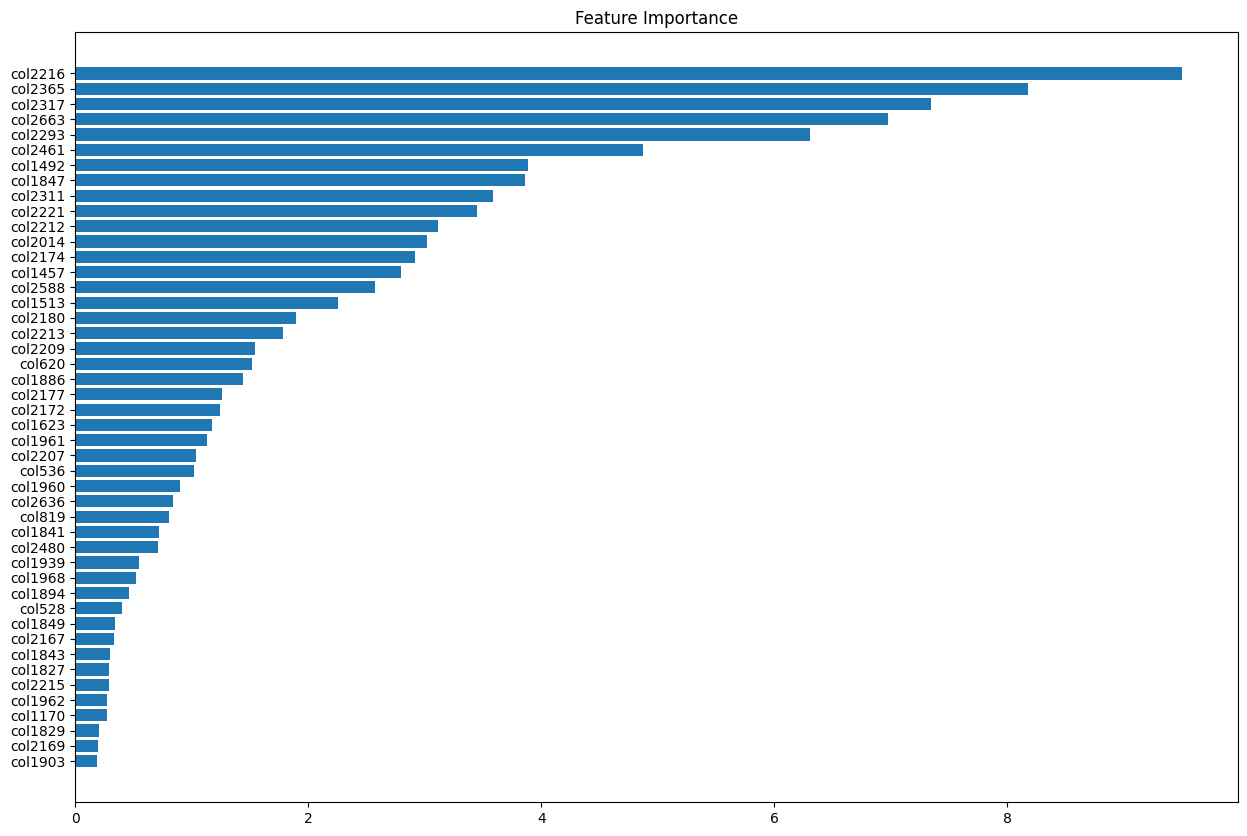

['col2216' 'col2365' 'col2317' 'col2663' 'col2293' 'col2461' 'col1492'
 'col1847' 'col2311' 'col2221' 'col2212' 'col2014' 'col2174' 'col1457'
 'col2588' 'col1513' 'col2180' 'col2213' 'col2209' 'col620' 'col1886'
 'col2177' 'col2172' 'col1623' 'col1961' 'col2207' 'col536' 'col1960'
 'col2636' 'col819' 'col1841' 'col2480' 'col1939' 'col1968' 'col1894'
 'col528' 'col1849' 'col2167' 'col1843' 'col1827' 'col2215' 'col1962'
 'col1170' 'col1829' 'col2169' 'col1903']


In [19]:
boosting = Boosting(X_train, X_val, X_oot, y_train, y_val, y_oot, cat_features = final_categ_feats)

boosting.train()
boosting.score_oot()
boosting.show_feats_imp()

100%|██████████| 46/46 [01:23<00:00,  1.82s/it]


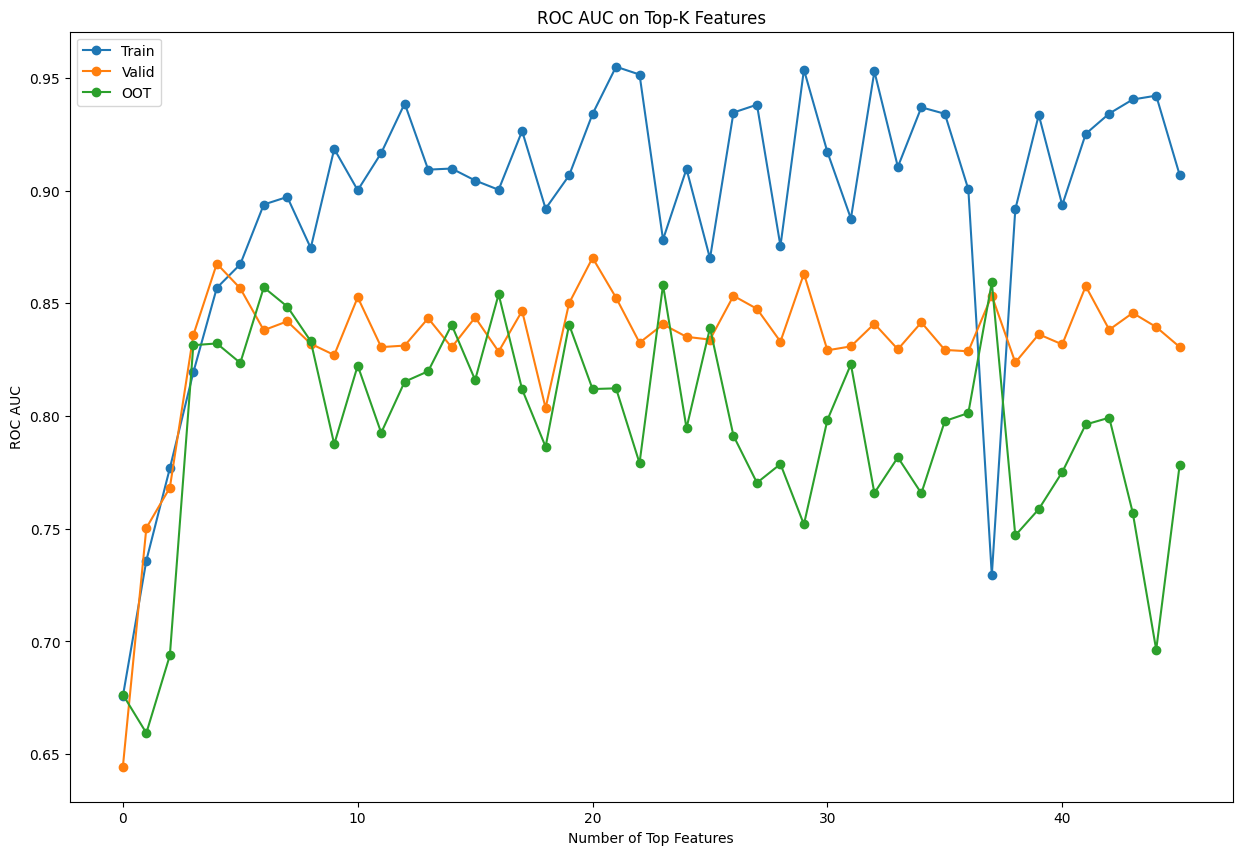

In [20]:
boosting.top_feats_selection()

In [21]:
boosting.save_model("../models/boosting_1.pkl")

# Обучение на топ фичах по графику выше

In [22]:
top_feats = ['col2365', 'col2293', 'col2216', 'col2588', 'col2663', 'col1847', 'col2317',
            'col1973', 'col2311', 'col2213', 'col2505', 'col2461', 'col1492', 'col1824',
            'col2014', 'col2221', 'col1513', 'col1886', 'col1843', 'col1894', 'col2180',
            'col1623', 'col620', 'col2174', 'col2172', 'col536', 'col1827', 'col1961',
            'col1457', 'col1829', 'col2636', 'col2215', 'col1939', 'col1903', 'col2169',
            'col2207', 'col2209', 'col2173', 'col2480', 'col1170', 'col1962', 'col819',
            'col2167', 'col2177', 'col2212', 'col1841']

In [23]:
top_num_feats = df[top_feats[:25]].select_dtypes('number').columns.unique().tolist()

top_categ_feats = df[top_feats[:25]].select_dtypes('object').columns.unique().tolist()

In [24]:
X_train = df[df['sample'] == 'Train'][top_num_feats+top_categ_feats]
X_val = df[df['sample'] == 'Valid'][top_num_feats+top_categ_feats]
X_oot = df[df['sample'] == 'OOT'][top_num_feats+top_categ_feats]

y_train = df[df['sample'] == 'Train'][target]
y_val = df[df['sample'] == 'Valid'][target]
y_oot = df[df['sample'] == 'OOT'][target]

In [25]:
boosting_2 = Boosting(X_train, X_val, X_oot, y_train, y_val, y_oot, cat_features = top_categ_feats)

Init...
Init Finished!


0:	test: 0.5000000	best: 0.5000000 (0)	total: 2.63ms	remaining: 2.63s
100:	test: 0.8285630	best: 0.8463311 (65)	total: 415ms	remaining: 3.69s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8463310942
bestIteration = 65

Shrink model to first 66 iterations.
ROC AUC на TRAIN выборке: 0.9026951522570796
ROC AUC на VALID выборке: 0.8463310941660614
ROC AUC на OOT выборке: 0.8106087735004477


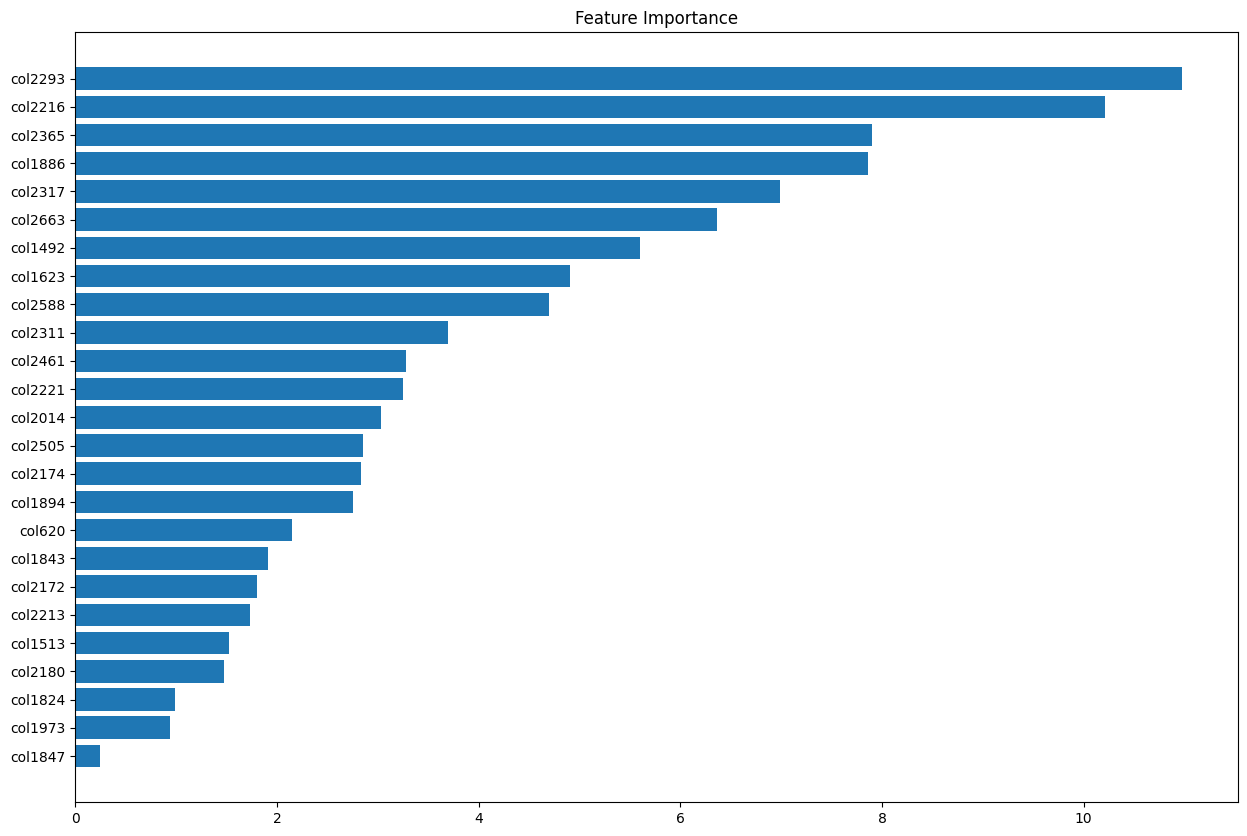

['col2293' 'col2216' 'col2365' 'col1886' 'col2317' 'col2663' 'col1492'
 'col1623' 'col2588' 'col2311' 'col2461' 'col2221' 'col2014' 'col2505'
 'col2174' 'col1894' 'col620' 'col1843' 'col2172' 'col2213' 'col1513'
 'col2180' 'col1824' 'col1973' 'col1847']


In [26]:
boosting_2.train()
boosting_2.score_oot()
boosting_2.show_feats_imp()

100%|██████████| 25/25 [00:54<00:00,  2.17s/it]


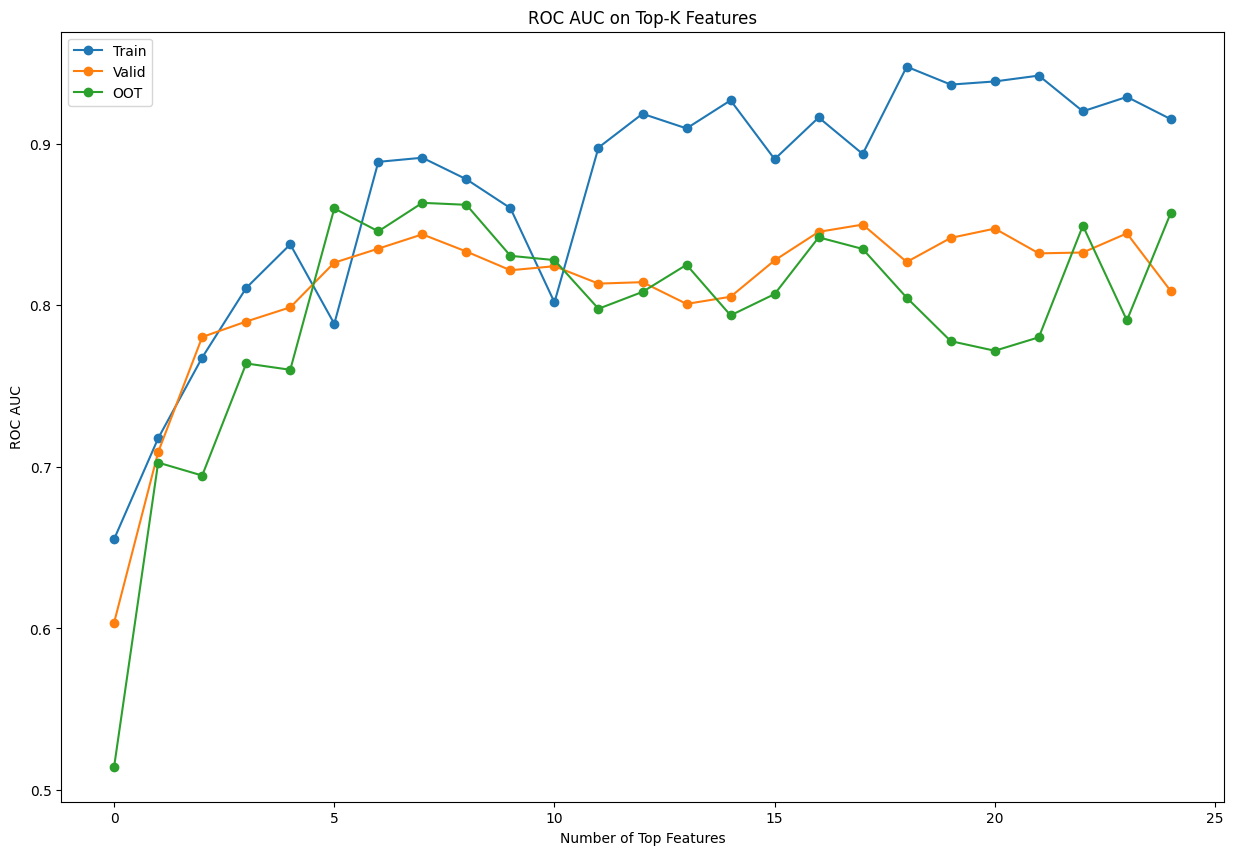

In [27]:
boosting_2.top_feats_selection()

In [28]:
boosting_2.save_model("../models/boosting_2.pkl")

# Самый финальный отбор фичей и обучение финальной модели

In [29]:
top_feats = ['col1623', 'col2213', 'col2216', 'col2311', 'col2317', 'col2293', 'col2663']

In [30]:
top_num_feats = df[top_feats].select_dtypes('number').columns.unique().tolist()

top_categ_feats = df[top_feats].select_dtypes('object').columns.unique().tolist()

In [31]:
X_train = df[df['sample'] == 'Train'][top_num_feats+top_categ_feats]
X_val = df[df['sample'] == 'Valid'][top_num_feats+top_categ_feats]
X_oot = df[df['sample'] == 'OOT'][top_num_feats+top_categ_feats]

y_train = df[df['sample'] == 'Train'][target]
y_val = df[df['sample'] == 'Valid'][target]
y_oot = df[df['sample'] == 'OOT'][target]

In [32]:
boosting_3 = Boosting(X_train, X_val, X_oot, y_train, y_val, y_oot, cat_features = top_categ_feats)

Init...
Init Finished!


In [33]:
boosting_3.train()

0:	test: 0.5000000	best: 0.5000000 (0)	total: 2.75ms	remaining: 2.75s
100:	test: 0.7930359	best: 0.8157453 (16)	total: 282ms	remaining: 2.51s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8157452796
bestIteration = 16

Shrink model to first 17 iterations.
ROC AUC на TRAIN выборке: 0.7713651693424967
ROC AUC на VALID выборке: 0.8157452795933189


In [35]:
boosting_3.score_oot()
boosting_3.save_model("../models/boosting_3.pkl")

ROC AUC на OOT выборке: 0.8504252461951657


# Отбор гиперпараметров

In [147]:
boosting_2.optimize_hyperparams()

[I 2023-09-09 16:35:34,602] A new study created in memory with name: no-name-a9559cc6-eda0-4306-b9a5-e884efc3648e
[I 2023-09-09 16:35:40,016] Trial 0 finished with value: 0.840937424352457 and parameters: {'objective': 'Logloss', 'learning_rate': 0.003642095237792226, 'l2_leaf_reg': 1.875008848853694, 'colsample_bylevel': 0.029758139924923772, 'depth': 2, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 27, 'one_hot_max_size': 47, 'iterations': 3253}. Best is trial 0 with value: 0.840937424352457.
[I 2023-09-09 16:35:55,615] Trial 1 finished with value: 0.8369992132655532 and parameters: {'objective': 'Logloss', 'learning_rate': 0.0032242958430631578, 'l2_leaf_reg': 0.04061626026252108, 'colsample_bylevel': 0.013689298027229837, 'depth': 2, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 39, 'one_hot_max_size': 10, 'iterations': 2440}. Best is trial 0 with value: 0.840937424352457.
[I 2023-09-09 16:36:06,909] Trial 2 finished with value: 0

Best params: {'objective': 'Logloss', 'learning_rate': 0.09099691787199307, 'l2_leaf_reg': 0.2923733317804608, 'colsample_bylevel': 0.035717620996811715, 'depth': 4, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 17, 'one_hot_max_size': 33, 'iterations': 2169, 'bagging_temperature': 7.629969271454117}


In [149]:
boosting_3.optimize_hyperparams()

[I 2023-09-09 16:54:32,086] A new study created in memory with name: no-name-abbfc450-459c-4d83-96a5-1224d827db58
[I 2023-09-09 16:54:34,160] Trial 0 finished with value: 0.8472207092713628 and parameters: {'objective': 'Logloss', 'learning_rate': 0.003257093423697688, 'l2_leaf_reg': 0.7132915022220596, 'colsample_bylevel': 0.04565146765182273, 'depth': 2, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 23, 'one_hot_max_size': 15, 'iterations': 1415}. Best is trial 0 with value: 0.8472207092713628.
[I 2023-09-09 16:54:41,638] Trial 1 finished with value: 0.8370839385136771 and parameters: {'objective': 'Logloss', 'learning_rate': 0.00017995812918524684, 'l2_leaf_reg': 0.31870980589788706, 'colsample_bylevel': 0.022537171541455743, 'depth': 2, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 21, 'one_hot_max_size': 43, 'iterations': 990, 'subsample': 0.14499770804861373}. Best is trial 0 with value: 0.8472207092713628.
[I 2023-09-09 1

Best params: {'objective': 'Logloss', 'learning_rate': 0.00016154885644915093, 'l2_leaf_reg': 0.25168173395343224, 'colsample_bylevel': 0.029296304299612275, 'depth': 4, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 25, 'one_hot_max_size': 43, 'iterations': 3300, 'bagging_temperature': 6.280380230862912}


In [36]:
best_params = {'objective': 'Logloss',
                'learning_rate': 0.09099691787199307,
                'l2_leaf_reg': 0.2923733317804608,
                'colsample_bylevel': 0.035717620996811715,
                'depth': 4,
                'boosting_type': 'Plain',
                'bootstrap_type': 'Bayesian',
                'min_data_in_leaf': 17,
                'one_hot_max_size': 33,
                'iterations': 2169,
                'bagging_temperature': 7.629969271454117}

In [37]:
top_feats = ['col2365', 'col2293', 'col2216', 'col2588', 'col2663', 'col1847', 'col2317',
            'col1973', 'col2311', 'col2213', 'col2505', 'col2461', 'col1492', 'col1824',
            'col2014', 'col2221', 'col1513', 'col1886', 'col1843', 'col1894', 'col2180',
            'col1623', 'col620', 'col2174', 'col2172', 'col536', 'col1827', 'col1961',
            'col1457', 'col1829', 'col2636', 'col2215', 'col1939', 'col1903', 'col2169',
            'col2207', 'col2209', 'col2173', 'col2480', 'col1170', 'col1962', 'col819',
            'col2167', 'col2177', 'col2212', 'col1841']

In [38]:
top_num_feats = df[top_feats[:25]].select_dtypes('number').columns.unique().tolist()

top_categ_feats = df[top_feats[:25]].select_dtypes('object').columns.unique().tolist()

In [39]:
X_train = df[df['sample'] == 'Train'][top_num_feats+top_categ_feats]
X_val = df[df['sample'] == 'Valid'][top_num_feats+top_categ_feats]
X_oot = df[df['sample'] == 'OOT'][top_num_feats+top_categ_feats]

y_train = df[df['sample'] == 'Train'][target]
y_val = df[df['sample'] == 'Valid'][target]
y_oot = df[df['sample'] == 'OOT'][target]

In [40]:
boosting_4 = Boosting(X_train, X_val, X_oot, y_train, y_val, y_oot, cat_features = top_categ_feats, params = best_params)

Init...
Init Finished!


In [42]:
boosting_4.train()
boosting_4.score_oot()

0:	learn: 0.5354433	test: 0.5421945	best: 0.5421945 (0)	total: 2.42ms	remaining: 2.42s
100:	learn: 0.0857928	test: 0.0930214	best: 0.0930082 (97)	total: 266ms	remaining: 2.37s
200:	learn: 0.0819919	test: 0.0905097	best: 0.0904960 (195)	total: 537ms	remaining: 2.13s
300:	learn: 0.0764417	test: 0.0893772	best: 0.0893715 (293)	total: 828ms	remaining: 1.92s
400:	learn: 0.0732112	test: 0.0890504	best: 0.0885691 (389)	total: 1.23s	remaining: 1.83s
500:	learn: 0.0707092	test: 0.0891338	best: 0.0885691 (389)	total: 1.8s	remaining: 1.79s
600:	learn: 0.0688748	test: 0.0890038	best: 0.0885691 (389)	total: 2.36s	remaining: 1.57s
700:	learn: 0.0666799	test: 0.0891647	best: 0.0885691 (389)	total: 2.93s	remaining: 1.25s
800:	learn: 0.0648845	test: 0.0885932	best: 0.0885261 (772)	total: 3.31s	remaining: 823ms
900:	learn: 0.0629380	test: 0.0889373	best: 0.0882316 (887)	total: 3.58s	remaining: 393ms
999:	learn: 0.0612999	test: 0.0888095	best: 0.0882316 (887)	total: 3.87s	remaining: 0us

bestTest = 0.088

# ROC-AUC по поколениям

In [47]:
with open("../models/boosting_1.pkl", 'rb') as file:
    boosting1 = pickle.load(file)

with open("../models/boosting_2.pkl", 'rb') as file:
    boosting2 = pickle.load(file)

with open("../models/boosting_3.pkl", 'rb') as file:
    boosting3 = pickle.load(file)

In [43]:
scoring_data = data.copy()
scoring_data = scoring_data[final_num_feats+final_categ_feats+extras+target]

In [44]:
convert_to_float(scoring_data)

100%|██████████| 117/117 [00:05<00:00, 21.64it/s]


In [48]:
scoring_data[final_categ_feats] = scoring_data[final_categ_feats].fillna("999")
scoring_data[final_categ_feats] = scoring_data[final_categ_feats].astype(str)

scoring_data = scoring_data[scoring_data['report_date'] < '2022-02-01']

preds1 = boosting1.predict_proba(scoring_data[boosting1.feature_names_])[:, 1]
preds2 = boosting2.predict_proba(scoring_data[boosting2.feature_names_])[:, 1]
preds3 = boosting3.predict_proba(scoring_data[boosting3.feature_names_])[:, 1]

In [49]:
scoring_data["BOOSTING_1"] = preds1
scoring_data["BOOSTING_2"] = preds2
scoring_data["BOOSTING_3"] = preds3

In [50]:
print(f"ROC-AUC на всей выборке для первой модели: {roc_auc_score(scoring_data['target'], scoring_data['BOOSTING_1'])}")
print(f"ROC-AUC на всей выборке для второй модели: {roc_auc_score(scoring_data['target'], scoring_data['BOOSTING_2'])}")
print(f"ROC-AUC на всей выборке для третьей модели: {roc_auc_score(scoring_data['target'], scoring_data['BOOSTING_3'])}")

ROC-AUC на всей выборке для первой модели: 0.8235373557244511
ROC-AUC на всей выборке для второй модели: 0.8172711602774281
ROC-AUC на всей выборке для третьей модели: 0.7286154621810224


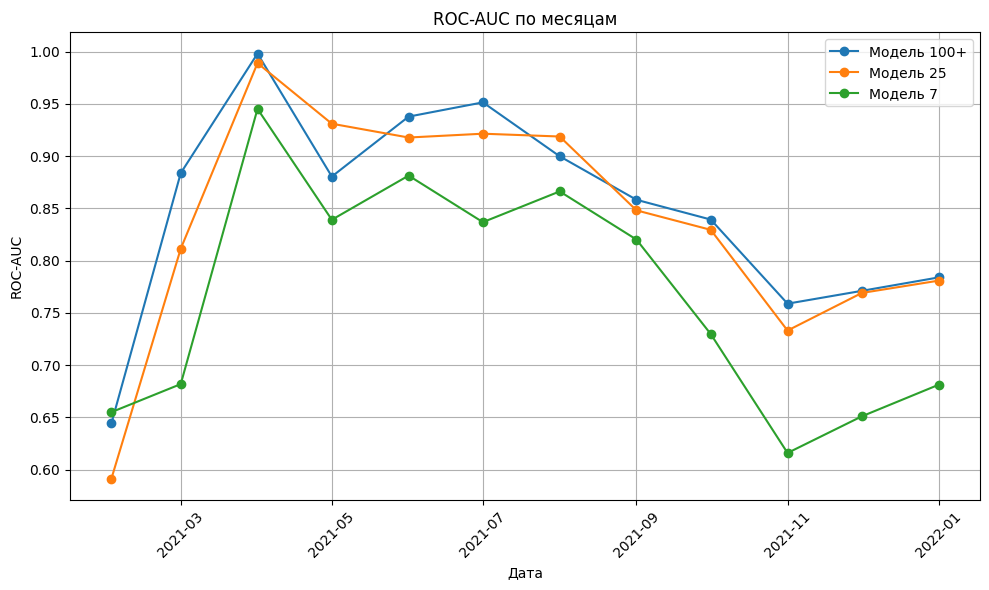

In [51]:
# ROC-AUC по месяцам
scoring_data['report_date'] = pd.to_datetime(scoring_data['report_date'])

roc_auc_scores_1 = scoring_data.groupby('report_date').apply(lambda group: roc_auc_score(group['target'], group['BOOSTING_1']))
roc_auc_scores_2 = scoring_data.groupby('report_date').apply(lambda group: roc_auc_score(group['target'], group['BOOSTING_2']))
roc_auc_scores_3 = scoring_data.groupby('report_date').apply(lambda group: roc_auc_score(group['target'], group['BOOSTING_3']))

plt.figure(figsize=(10, 6))
plt.plot(roc_auc_scores_1.index, roc_auc_scores_1.values, marker='o', label = 'Модель 100+')
plt.plot(roc_auc_scores_2.index, roc_auc_scores_2.values, marker='o', label = 'Модель 25')
plt.plot(roc_auc_scores_3.index, roc_auc_scores_3.values, marker='o', label = 'Модель 7')
plt.title('ROC-AUC по месяцам')
plt.xlabel('Дата')
plt.ylabel('ROC-AUC')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()